
# **Extract news category dataset and build a dummy classifier**
# Dataset:
  1000 subset of news from [News category dataset](https://rishabhmisra.github.io/publications) that contains news headlines with around 42 categories.
# Steps:
1.   Import needed libraries
2.   Text preprocessing (tokenization, stop word removal, punctuation removal, and lemmatization)
3.   Using pandas to transform the datasets
4.   Build a dummy classifier using scikit-learn



In [ ]:
# Importing libraries
import pandas as pd
import json
from pandas import DataFrame as df
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import spacy
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
import pickle
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
cd /root/nltk_data/corpora

/root/nltk_data/corpora


In [ ]:
!ls

stopwords  stopwords.zip  wordnet  wordnet.zip


In [ ]:
!unzip wordnet.zip

Archive:  wordnet.zip
replace wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: wordnet/lexnames        
  inflating: wordnet/data.verb       
  inflating: wordnet/index.adv       
  inflating: wordnet/adv.exc         
  inflating: wordnet/index.verb      
  inflating: wordnet/cntlist.rev     
  inflating: wordnet/data.adj        
  inflating: wordnet/index.adj       
  inflating: wordnet/LICENSE         
  inflating: wordnet/citation.bib    
  inflating: wordnet/noun.exc        
  inflating: wordnet/verb.exc        
  inflating: wordnet/README          
  inflating: wordnet/index.sense     
  inflating: wordnet/data.noun       
  inflating: wordnet/data.adv        
  inflating: wordnet/index.noun      
  inflating: wordnet/adj.exc         


In [ ]:
data ={}
def read_json_file(file):
    with open(file, "r") as r:
        response = r.read()
        response = response.replace('\n', '')
        response = response.replace('}{', '},{')
        response = "[" + response + "]"
        return json.loads(response)

response = read_json_file("/content/newstext_1000.json")
data["News"] = response
df2 = json_normalize(data['News'])

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   link               999 non-null    object
 1   headline           999 non-null    object
 2   category           999 non-null    object
 3   short_description  999 non-null    object
 4   authors            999 non-null    object
 5   date               999 non-null    object
dtypes: object(6)
memory usage: 47.0+ KB


In [ ]:
print("Number of categories = ",df2['category'].nunique())

Number of categories =  24


In [ ]:
df2['category'].value_counts()

POLITICS          272
ENTERTAINMENT     185
U.S. NEWS         173
WORLD NEWS        138
SPORTS             36
CRIME              26
ENVIRONMENT        25
CULTURE & ARTS     23
WELLNESS           16
PARENTING          15
WEIRD NEWS         14
FOOD & DRINK       14
COMEDY             11
BUSINESS            9
STYLE & BEAUTY      9
TECH                8
SCIENCE             5
WOMEN               5
EDUCATION           3
MEDIA               3
HOME & LIVING       3
BLACK VOICES        3
QUEER VOICES        2
TRAVEL              1
Name: category, dtype: int64

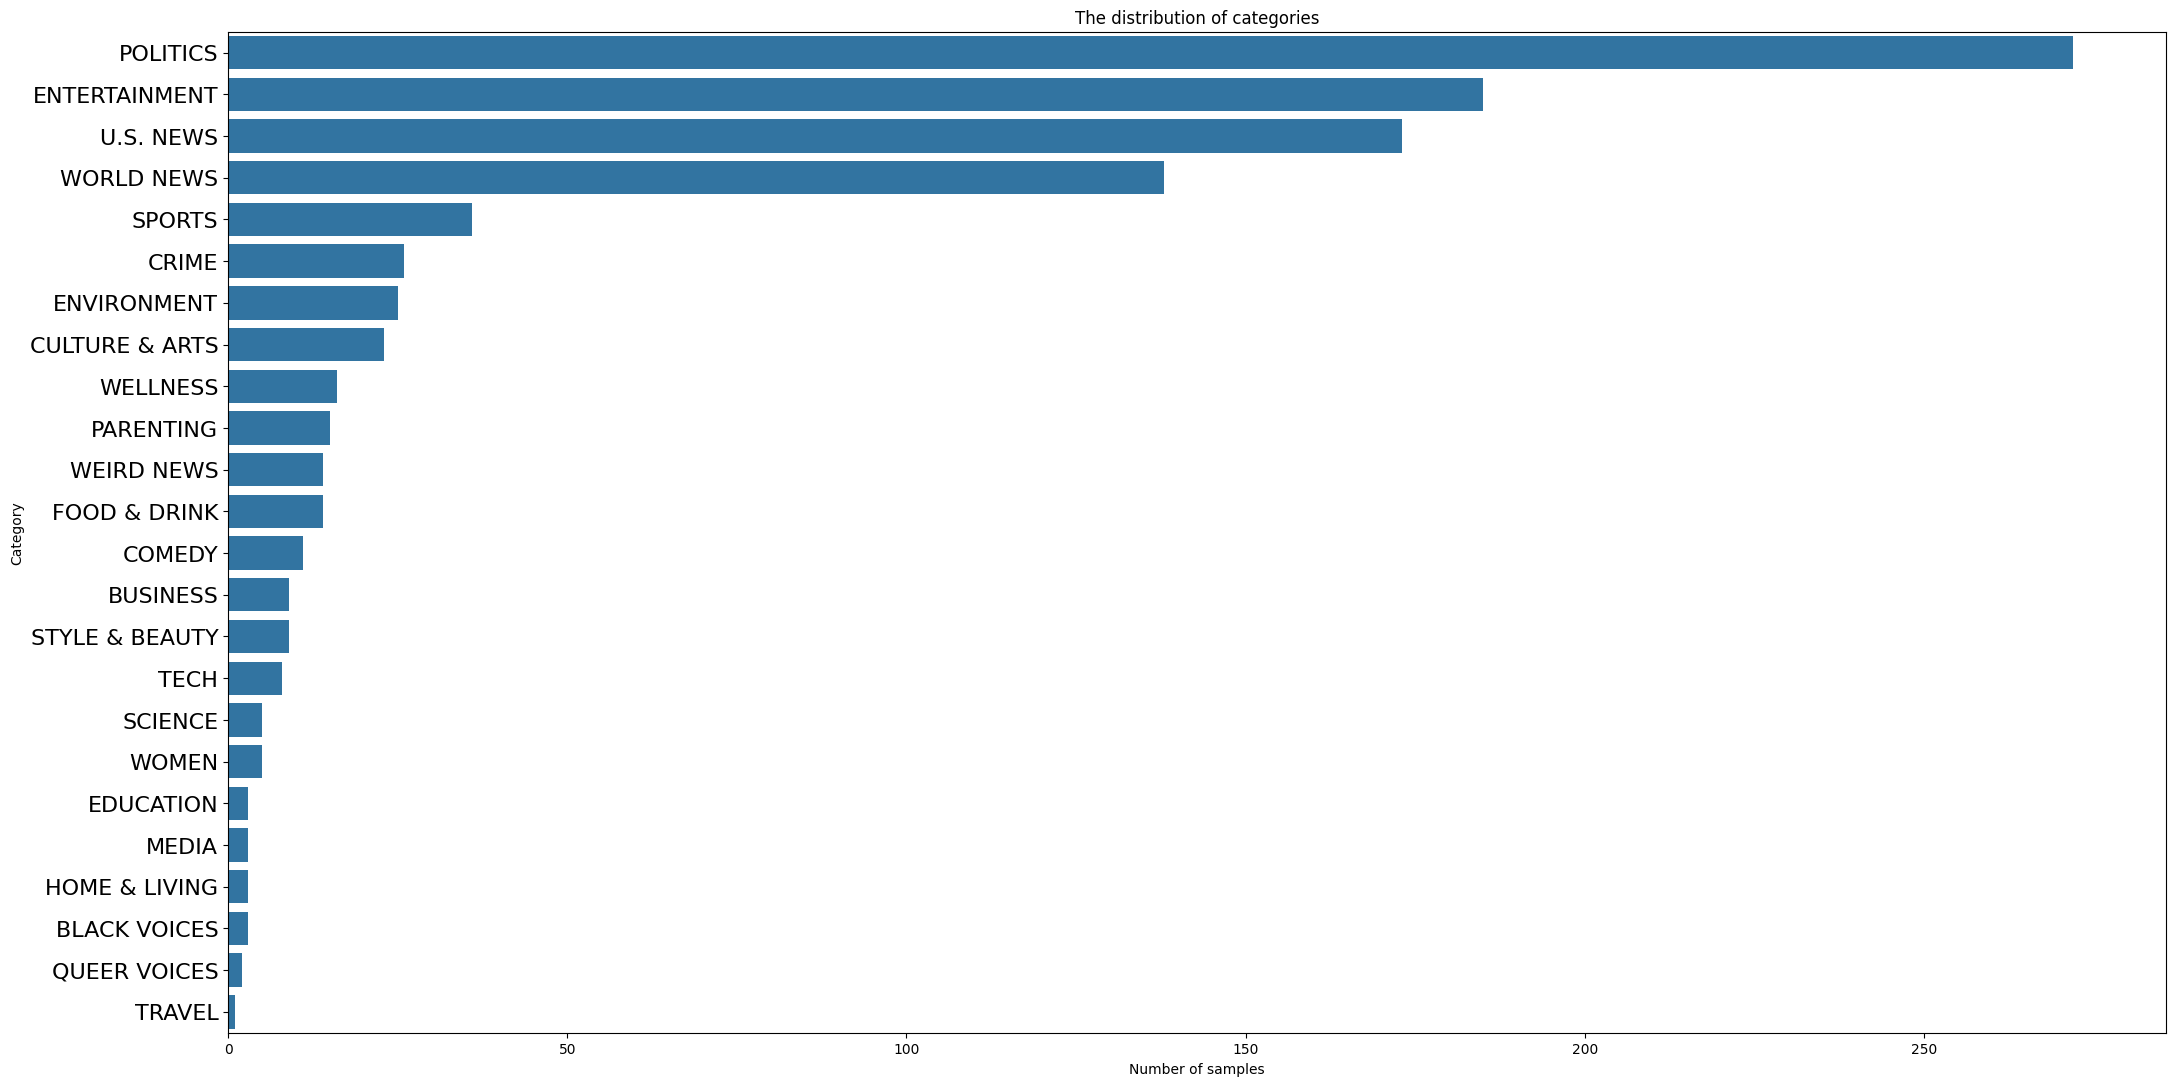

In [ ]:
plt.figure(figsize=(25,13))
sns.barplot(y=df2['category'].value_counts().index,x=df2['category'].value_counts().values)
plt.title("The distribution of categories")
plt.xlabel("Number of samples")
plt.ylabel("Category")

plt.yticks(rotation=0,fontsize = 16)
plt.show()

In [ ]:
#Concatenate headline and short_description into a full_article column
df2['full_article'] = df2['headline'] + " " + df2['short_description']

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower() #convert to lowercase letters
    tokens = nltk.word_tokenize(text) #word tokenization
    tokens = [token for token in tokens if token.isalpha()] #Remove puncutations and numbers
    tokens = [token for token in tokens if token not in stop_words] #Remove Stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens] #Lemmitization

    return tokens

In [ ]:
df2.loc[:, ('full_article_tokens')] = df2.loc[:,('full_article')].apply(lambda x: preprocess(x))
print(df2)

                                                  link  \
0    https://www.huffpost.com/entry/covid-boosters-...   
1    https://www.huffpost.com/entry/american-airlin...   
2    https://www.huffpost.com/entry/funniest-tweets...   
3    https://www.huffpost.com/entry/funniest-parent...   
4    https://www.huffpost.com/entry/amy-cooper-lose...   
..                                                 ...   
994  https://www.huffpost.com/entry/ap-lt-peru-fuji...   
995  https://www.huffpost.com/entry/china-weighs-ex...   
996  https://www.huffpost.com/entry/russian-missile...   
997  https://www.huffpost.com/entry/assad-uae_n_623...   
998  https://www.huffpost.com/entry/japan-earthquak...   

                                              headline    category  \
0    Over 4 Million Americans Roll Up Sleeves For O...   U.S. NEWS   
1    American Airlines Flyer Charged, Banned For Li...   U.S. NEWS   
2    23 Of The Funniest Tweets About Cats And Dogs ...      COMEDY   
3    The Funniest Tweet

In [ ]:
df2['news_len'] = df2['full_article'].apply(lambda x: len(x))

In [ ]:
df2.groupby('category')['news_len'].mean().reset_index().sort_values(by='news_len',ascending=False)

,category,news_len
5,EDUCATION,232.666667
4,CULTURE & ARTS,217.608696
13,QUEER VOICES,199.000000
12,POLITICS,198.301471
23,WORLD NEWS,196.311594
3,CRIME,196.230769
17,TECH,194.625000
19,U.S. NEWS,191.907514
0,BLACK VOICES,191.666667
15,SPORTS,189.083333


In [ ]:
df2.reset_index(inplace = True, drop = True)
print(df2)

                                                  link  \
0    https://www.huffpost.com/entry/covid-boosters-...   
1    https://www.huffpost.com/entry/american-airlin...   
2    https://www.huffpost.com/entry/funniest-tweets...   
3    https://www.huffpost.com/entry/funniest-parent...   
4    https://www.huffpost.com/entry/amy-cooper-lose...   
..                                                 ...   
994  https://www.huffpost.com/entry/ap-lt-peru-fuji...   
995  https://www.huffpost.com/entry/china-weighs-ex...   
996  https://www.huffpost.com/entry/russian-missile...   
997  https://www.huffpost.com/entry/assad-uae_n_623...   
998  https://www.huffpost.com/entry/japan-earthquak...   

                                              headline    category  \
0    Over 4 Million Americans Roll Up Sleeves For O...   U.S. NEWS   
1    American Airlines Flyer Charged, Banned For Li...   U.S. NEWS   
2    23 Of The Funniest Tweets About Cats And Dogs ...      COMEDY   
3    The Funniest Tweet

In [ ]:
# Calculate outliers
count = 0
max_threshold = df2['news_len'].std() *3 + df2['news_len'].mean()
min_threshold = abs(df2['news_len'].mean() - df2['news_len'].std()*3)
for num in df2['news_len']:
    if num > max_threshold or num < min_threshold:
      count += 1
print("The total outliers are = ",count)

The total outliers are =  5


In [ ]:
# Remove the outliers to improve the distribution
filtered_data = df2[(df2['news_len'] < max_threshold) & (df2['news_len'] > min_threshold )]
filtered_data.shape

(994, 9)

In [ ]:
# Remmove irrelevant data
filtered_data.drop(['authors','date', 'link'], axis=1, inplace = True)
filtered_data.head()

<ipython-input-27-50ae39b2c4da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.drop(['link'], axis=1, inplace = True)


,headline,category,short_description,full_article,full_article_tokens,news_len
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...,"[million, american, roll, sleeve, covid, boost...",231
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li...","[american, airline, flyer, charged, banned, li...",249
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...,"[funniest, tweet, cat, dog, week, dog, underst...",134
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...,"[funniest, tweet, parent, week, accidentally, ...",216
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...,"[woman, called, cop, black, loses, lawsuit, am...",234


In [ ]:
filtered_data['category'].value_counts()

POLITICS          268
ENTERTAINMENT     185
U.S. NEWS         173
WORLD NEWS        137
SPORTS             36
CRIME              26
ENVIRONMENT        25
CULTURE & ARTS     23
WELLNESS           16
PARENTING          15
WEIRD NEWS         14
FOOD & DRINK       14
COMEDY             11
BUSINESS            9
STYLE & BEAUTY      9
TECH                8
SCIENCE             5
WOMEN               5
EDUCATION           3
MEDIA               3
HOME & LIVING       3
BLACK VOICES        3
QUEER VOICES        2
TRAVEL              1
Name: category, dtype: int64

In [ ]:
# Define the target count for resampling (e.g., maximum count among all categories)
target_count = filtered_data['category'].value_counts().max()

# Initialize an empty DataFrame to store the resampled data
balanced_data = pd.DataFrame()

# Iterate over unique categories
for category in filtered_data['category'].unique():
    # Filter data for the current category
    category_data = filtered_data[filtered_data['category'] == category]

    # Determine the number of samples to resample based on the target count
    if len(category_data) >= target_count:
        n_samples = target_count
    else:
        n_samples = target_count - len(category_data)

    # Resample the data with replacement if necessary
    if len(category_data) >= target_count:
        sampled_data = resample(category_data, replace=False, n_samples=n_samples, random_state=42)
    else:
        sampled_data = resample(category_data, replace=True, n_samples=n_samples, random_state=42)

    # Concatenate the resampled data with the balanced data
    balanced_data = pd.concat([balanced_data, sampled_data])

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
balanced_data['category'].value_counts()

POLITICS          268
TRAVEL            267
QUEER VOICES      266
EDUCATION         265
BLACK VOICES      265
HOME & LIVING     265
MEDIA             265
WOMEN             263
SCIENCE           263
TECH              260
STYLE & BEAUTY    259
BUSINESS          259
COMEDY            257
FOOD & DRINK      254
WEIRD NEWS        254
PARENTING         253
WELLNESS          252
CULTURE & ARTS    245
ENVIRONMENT       243
CRIME             242
SPORTS            232
WORLD NEWS        131
U.S. NEWS          95
ENTERTAINMENT      83
Name: category, dtype: int64

In [ ]:
X = balanced_data.loc[:,filtered_data.columns != 'category']
X.head()

,headline,short_description,full_article,full_article_tokens,news_len
0,Rain Cascades From Vegas Casino Ceilings As Th...,Parts of the parched southwest are now being h...,Rain Cascades From Vegas Casino Ceilings As Th...,"[rain, cascade, vega, casino, ceiling, thunder...",191
1,Facebook Is Still Allowing Mug Shots Even Thou...,When an individual’s mug shot goes viral on Fa...,Facebook Is Still Allowing Mug Shots Even Thou...,"[facebook, still, allowing, mug, shot, even, t...",221
2,"If You're Doing This In Your Sleep, It's Time ...",Experts reveal symptoms that strike during nig...,"If You're Doing This In Your Sleep, It's Time ...","[sleep, time, see, doctor, expert, reveal, sym...",168
3,Fuel Leak Ruins NASA's 2nd Shot At Launching N...,"Part of the space agency's Artemis program, th...",Fuel Leak Ruins NASA's 2nd Shot At Launching N...,"[fuel, leak, ruin, nasa, shot, launching, new,...",145
4,The Biggest COVID Issues People Bring Up In Th...,Mental health experts reveal the common pandem...,The Biggest COVID Issues People Bring Up In Th...,"[biggest, covid, issue, people, bring, therapy...",174


In [ ]:
y = balanced_data['category']

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(4564, 5)
(1142, 5)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(4564,)
(1142,)


In [ ]:
def classify_text(clf, doc, labels=None):
  probas = clf.predict_proba([doc]).flatten()
  max_proba_idx = np.argmax(probas)

  if labels:
    most_proba_class = labels[max_proba_idx]
  else:
    most_proba_class = max_proba_idx

  return (most_proba_class, probas[max_proba_idx])

In [ ]:
# Vectorize the training data
vectorizer =TfidfVectorizer(max_features=1000)

X_train_vectorized = vectorizer.fit_transform(X_train['full_article_tokens'].apply(lambda x: ' '.join(x)))
X_test_vectorized = vectorizer.transform(X_test['full_article_tokens'].apply(lambda x: ' '.join(x)))

In [ ]:
# Train a dummy classifier which guesses the category randomly.

dummy_clf_1 = DummyClassifier(strategy="uniform")
dummy_clf_1.fit(X_train_vectorized, y_train)


DummyClassifier(strategy='uniform')

In [65]:
class_labels = [sublist for sublist in set(filtered_data['category'])]
print(class_labels)

['SPORTS', 'CRIME', 'BLACK VOICES', 'QUEER VOICES', 'MEDIA', 'SCIENCE', 'CULTURE & ARTS', 'TRAVEL', 'TECH', 'WORLD NEWS', 'PARENTING', 'WELLNESS', 'COMEDY', 'EDUCATION', 'FOOD & DRINK', 'ENVIRONMENT', 'U.S. NEWS', 'BUSINESS', 'POLITICS', 'HOME & LIVING', 'ENTERTAINMENT', 'WOMEN', 'STYLE & BEAUTY', 'WEIRD NEWS']


In [ ]:
s = "government imposed a curfew"
classify_text(dummy_clf_1, s, class_labels)

('SPORTS', 0.041666666666666664)

In [ ]:
def predict_text(clf, sent_vec, labels=None):
  preds_proba = clf.predict_proba(sent_vec)
  max_value = np.max(preds_proba)
  if labels:
    # Find the index of the class label with maximum probability
    max_prob_index = np.argmax(preds_proba[0])

    # Get the class label and its corresponding probability
    max_prob_class_label = labels[max_prob_index]
    max_prob = preds_proba[0][max_prob_index]
    return (f"Class Label: {max_prob_class_label}, Probability: {max_prob}")

  else:
      return (f"Probability: {max_value}, attach labels to find out the topic")

In [ ]:
# extended: train a Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [ ]:
# Evaluate the NB classifier
predictions = nb_classifier.predict(X_test_vectorized)
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
                precision    recall  f1-score   support

  BLACK VOICES       0.91      1.00      0.96        43
      BUSINESS       0.96      1.00      0.98        49
        COMEDY       0.96      1.00      0.98        54
         CRIME       0.78      1.00      0.88        43
CULTURE & ARTS       0.87      1.00      0.93        53
     EDUCATION       0.96      1.00      0.98        47
 ENTERTAINMENT       1.00      0.09      0.17        22
   ENVIRONMENT       0.86      1.00      0.93        56
  FOOD & DRINK       1.00      1.00      1.00        55
 HOME & LIVING       1.00      1.00      1.00        57
         MEDIA       0.98      1.00      0.99        43
     PARENTING       0.94      1.00      0.97        44
      POLITICS       0.70      0.73      0.71        48
  QUEER VOICES       0.97      1.00      0.98        60
       SCIENCE       0.97      1.00      0.98        64
        SPORTS       0.92      1.00      0.96        46
STYLE & BEAUTY       1.0

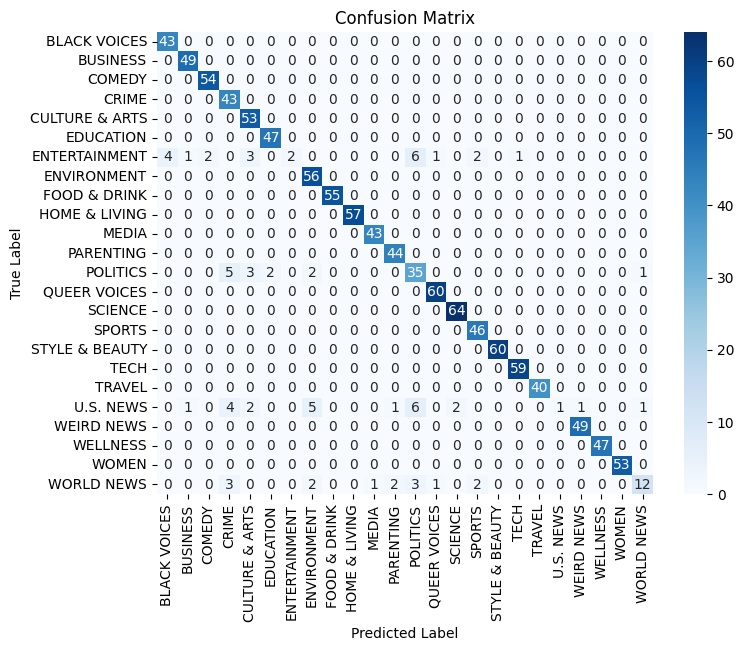

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Test sentence
s = ["government imposed a curfew"]

# Transform test data using the fitted vectorizer
x_test_feature_vector = vectorizer.transform(s)

# Classify text
predict_text(nb_classifier, x_test_feature_vector, class_labels)



'Class Label: POLITICS, Probability: 0.04973707274320773'

In [ ]:
# Test sentence
s = ["government announces new rules"]

# Transform test data using the fitted vectorizer
x_test_feature_vector = vectorizer.transform(s)

# Classify text
predict_text(nb_classifier, x_test_feature_vector, class_labels)

'Class Label: WORLD NEWS, Probability: 0.2750227279266871'

In [ ]:
filename = '/content/dummy_classification_model.pkl'
pickle.dump(dummy_clf_1, open(filename, 'wb'), -1)